## Observation
The loss surface around the converged solution shows regions of high curvature,
indicating sensitivity to perturbations consistent with earlier experiments.


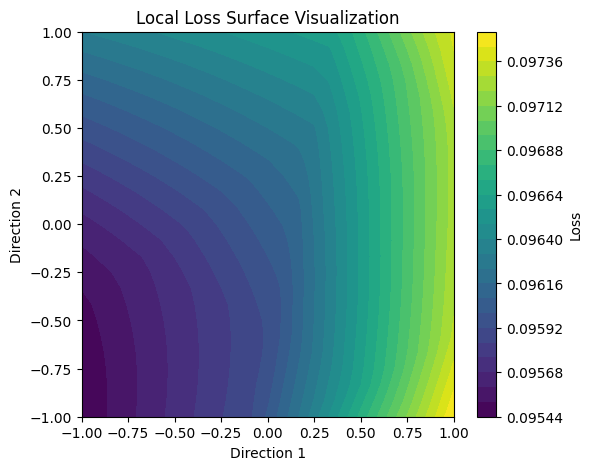

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model.load_state_dict(torch.load("../baseline_model.pth"))
model.eval()

criterion = nn.CrossEntropyLoss()

# Single batch for visualization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
data, target = next(iter(loader))
data, target = data.to(device), target.to(device)

# Flatten parameters
params = torch.cat([p.view(-1) for p in model.parameters()])
dim = params.numel()

# Random directions
d1 = torch.randn(dim).to(device)
d2 = torch.randn(dim).to(device)
d1 /= torch.norm(d1)
d2 /= torch.norm(d2)

alphas = np.linspace(-1, 1, 25)
loss_grid = np.zeros((len(alphas), len(alphas)))

original_params = params.clone()

for i, a in enumerate(alphas):
    for j, b in enumerate(alphas):
        new_params = original_params + a * d1 + b * d2

        idx = 0
        with torch.no_grad():
            for p in model.parameters():
                numel = p.numel()
                p.copy_(new_params[idx:idx+numel].view_as(p))
                idx += numel

        output = model(data)
        loss = criterion(output, target)
        loss_grid[i, j] = loss.item()

# Restore original params
idx = 0
with torch.no_grad():
    for p in model.parameters():
        numel = p.numel()
        p.copy_(original_params[idx:idx+numel].view_as(p))
        idx += numel

# Plot contour
plt.figure(figsize=(6, 5))
plt.contourf(alphas, alphas, loss_grid, levels=30)
plt.colorbar(label="Loss")
plt.xlabel("Direction 1")
plt.ylabel("Direction 2")
plt.title("Local Loss Surface Visualization")
plt.show()
